<a href="https://colab.research.google.com/github/Comfortxble/UROP-ABCD/blob/main/LogReg_sstfMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Load Packages**

In [10]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import sys
sys.path.append("/content/drive/MyDrive/vir_env/lib/python3.13/site-packages")

In [12]:
#Loading other packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score, RocCurveDisplay

### **Helper Function for Metrics**

In [13]:
def specicivity(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  return tn / (tn + fp)

In [14]:
def sensitivity(y_true, y_pred):
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  return tp / (tp + fn)

In [15]:
auc_list =[]
def store_auc(X, y_test, label, model):
  y_proba = model.predict_proba(X)[:,1]
  fpr, tpr, thresholds = roc_curve(y_test, y_proba)
  auc_list.append([fpr, tpr, label, auc(fpr, tpr)])

In [16]:
def auc_compare_plot(auc_list):
  plt.figure(figsize=(10, 6))

  for list in auc_list:
    fpr = list[0]
    tpr = list[1]
    label = list[2]
    auc_value = list[3]
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc_value:.2f})')

  plt.plot([0, 1], [0, 1], 'k--', label='Chance')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic Curves')
  plt.legend()
  plt.grid(True)
  plt.show()

In [17]:
def get_metrics(X, y, model):
  y_pred = model.predict(X)
  y_proba = model.predict_proba(X)[:,1]
  print(classification_report(y, y_pred))
  print(f"Accuracy: {accuracy_score(y, y_pred):.4f}")
  print(f"Recall: {recall_score(y, y_pred):.4f}")
  print(f"Sensitivity: {sensitivity(y, y_pred):.4f}")
  print(f"Specificity: {specicivity(y, y_pred):.4f}")
  print(f"AUC: {roc_auc_score(y, y_proba):.4f}")
  print(f"Average Precision: {average_precision_score(y, y_proba):.4f}")

In [18]:
def iteration_helper(c_values):
  for c in c_values:
    log_reg = LogisticRegression(random_state=1, class_weight='balanced', max_iter=2500,
                                penalty='l1', solver='liblinear', C=c)
    log_reg = log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    y_proba_v = log_reg.predict_proba(X_valid)[:,1]
    y_proba_t = log_reg.predict_proba(X_test)[:,1]

    recall.append(recall_score(y_test, y_pred))
    auc_valid.append(roc_auc_score(y_valid, y_proba_v))
    auc_test.append(roc_auc_score(y_test, y_proba_t))
    auprc.append(average_precision_score(y_test, y_proba_t))

## **Load Data + Data Separation**

In [19]:
df = pd.read_csv("/content/drive/MyDrive/UROP Data/sa_ppc_sstfMRI_train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/UROP Data/sa_ppc_sstfMRI_test.csv")

In [20]:
y = df['SuicideAttempt']
X = df.drop(['SuicideAttempt', 'subjectkey'], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
# stratify=y to mediate data imbalance

y_test = df_test['SuicideAttempt']
X_test = df_test.drop(['SuicideAttempt', 'subjectkey'], axis=1)

In [21]:
# Questionaire ONLY
X_train_q = X_train.iloc[:, 0:130]
X_valid_q = X_valid.iloc[:, 0:130]
X_test_q = X_test.iloc[:, 0:130]

# fMRI ONLY
X_train_mri = X_train.iloc[:, 130::]
X_valid_mri = X_valid.iloc[:, 130::]
X_test_mri = X_test.iloc[:, 130::]

## **Preliminary Model**

In [22]:
clf_model = LogisticRegression(random_state=1, class_weight='balanced',
                             n_jobs=-1, max_iter=1000)
log_reg = clf_model.fit(X_train, y_train)

get_metrics(X_valid, y_valid, log_reg)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1089
           1       0.00      0.00      0.00         7

    accuracy                           0.98      1096
   macro avg       0.50      0.49      0.49      1096
weighted avg       0.99      0.98      0.98      1096

Accuracy: 0.9781
Recall: 0.0000
Sensitivity: 0.0000
Specificity: 0.9844
AUC: 0.6661
Average Precision: 0.0125


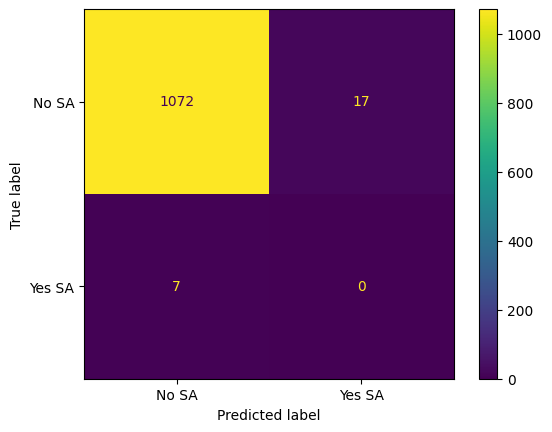

In [23]:
ConfusionMatrixDisplay.from_estimator(log_reg, X_valid, y_valid,
                                      display_labels=["No SA", "Yes SA"])

In [24]:
test_predict = log_reg.predict(X_test)
test_predict_proba = log_reg.predict_proba(X_test)[:,1]

get_metrics(X_test, y_test, log_reg)

              precision    recall  f1-score   support

           0       0.55      1.00      0.71        11
           1       0.00      0.00      0.00         9

    accuracy                           0.55        20
   macro avg       0.28      0.50      0.35        20
weighted avg       0.30      0.55      0.39        20

Accuracy: 0.5500
Recall: 0.0000
Sensitivity: 0.0000
Specificity: 1.0000
AUC: 0.5455
Average Precision: 0.5965


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


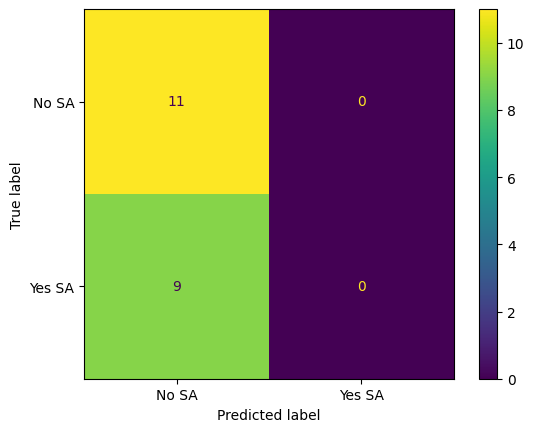

In [25]:
ConfusionMatrixDisplay.from_estimator(log_reg, X_test, y_test,
                                      display_labels=["No SA", "Yes SA"])

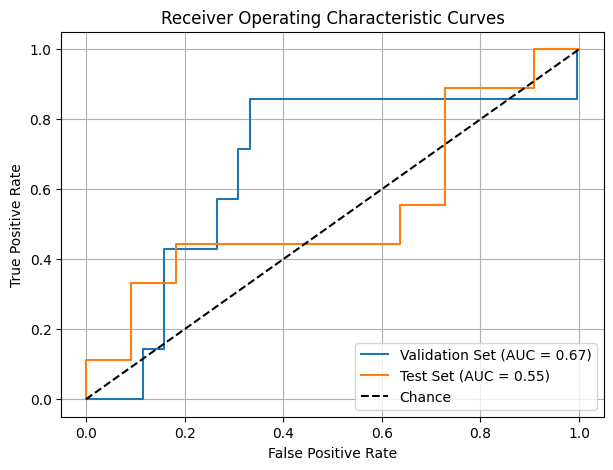

In [26]:
predict_proba_v = log_reg.predict_proba(X_valid)
predict_proba_t = log_reg.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_valid, predict_proba_v[:,1])
fpr0, tpr0, thresholds0 = roc_curve(y_test, predict_proba_t[:,1])
auc_ = auc(fpr, tpr)
auc0 = auc(fpr0, tpr0)

#plot auc roc
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'Validation Set (AUC = {auc_:.2f})')
plt.plot(fpr0, tpr0, label=f'Test Set (AUC = {auc0:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curves')
plt.legend()
plt.grid(True)
plt.show()

### Feature Importance

In [30]:
feature_names = X_train.columns

# Coefficients and Odds Ratios
coef = log_reg.coef_[0]
odds_ratios = np.exp(coef)

# Display feature importance using coefficients and odds ratios
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef,
    'Odds Ratio': odds_ratios
})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)
feature_importance.head(5)

,Feature,Coefficient,Odds Ratio
27,income_1,0.590434,1.804771
151,tfmri_sst_all_correct.go.vs.fixation_beta_cort...,0.574555,1.776340
64,vol,0.573384,1.774261
255,tfmri_sst_all_correct.go.vs.fixation_beta_cort...,0.568198,1.765083
70,nihtbx_list_uncorrected,0.547610,1.729115


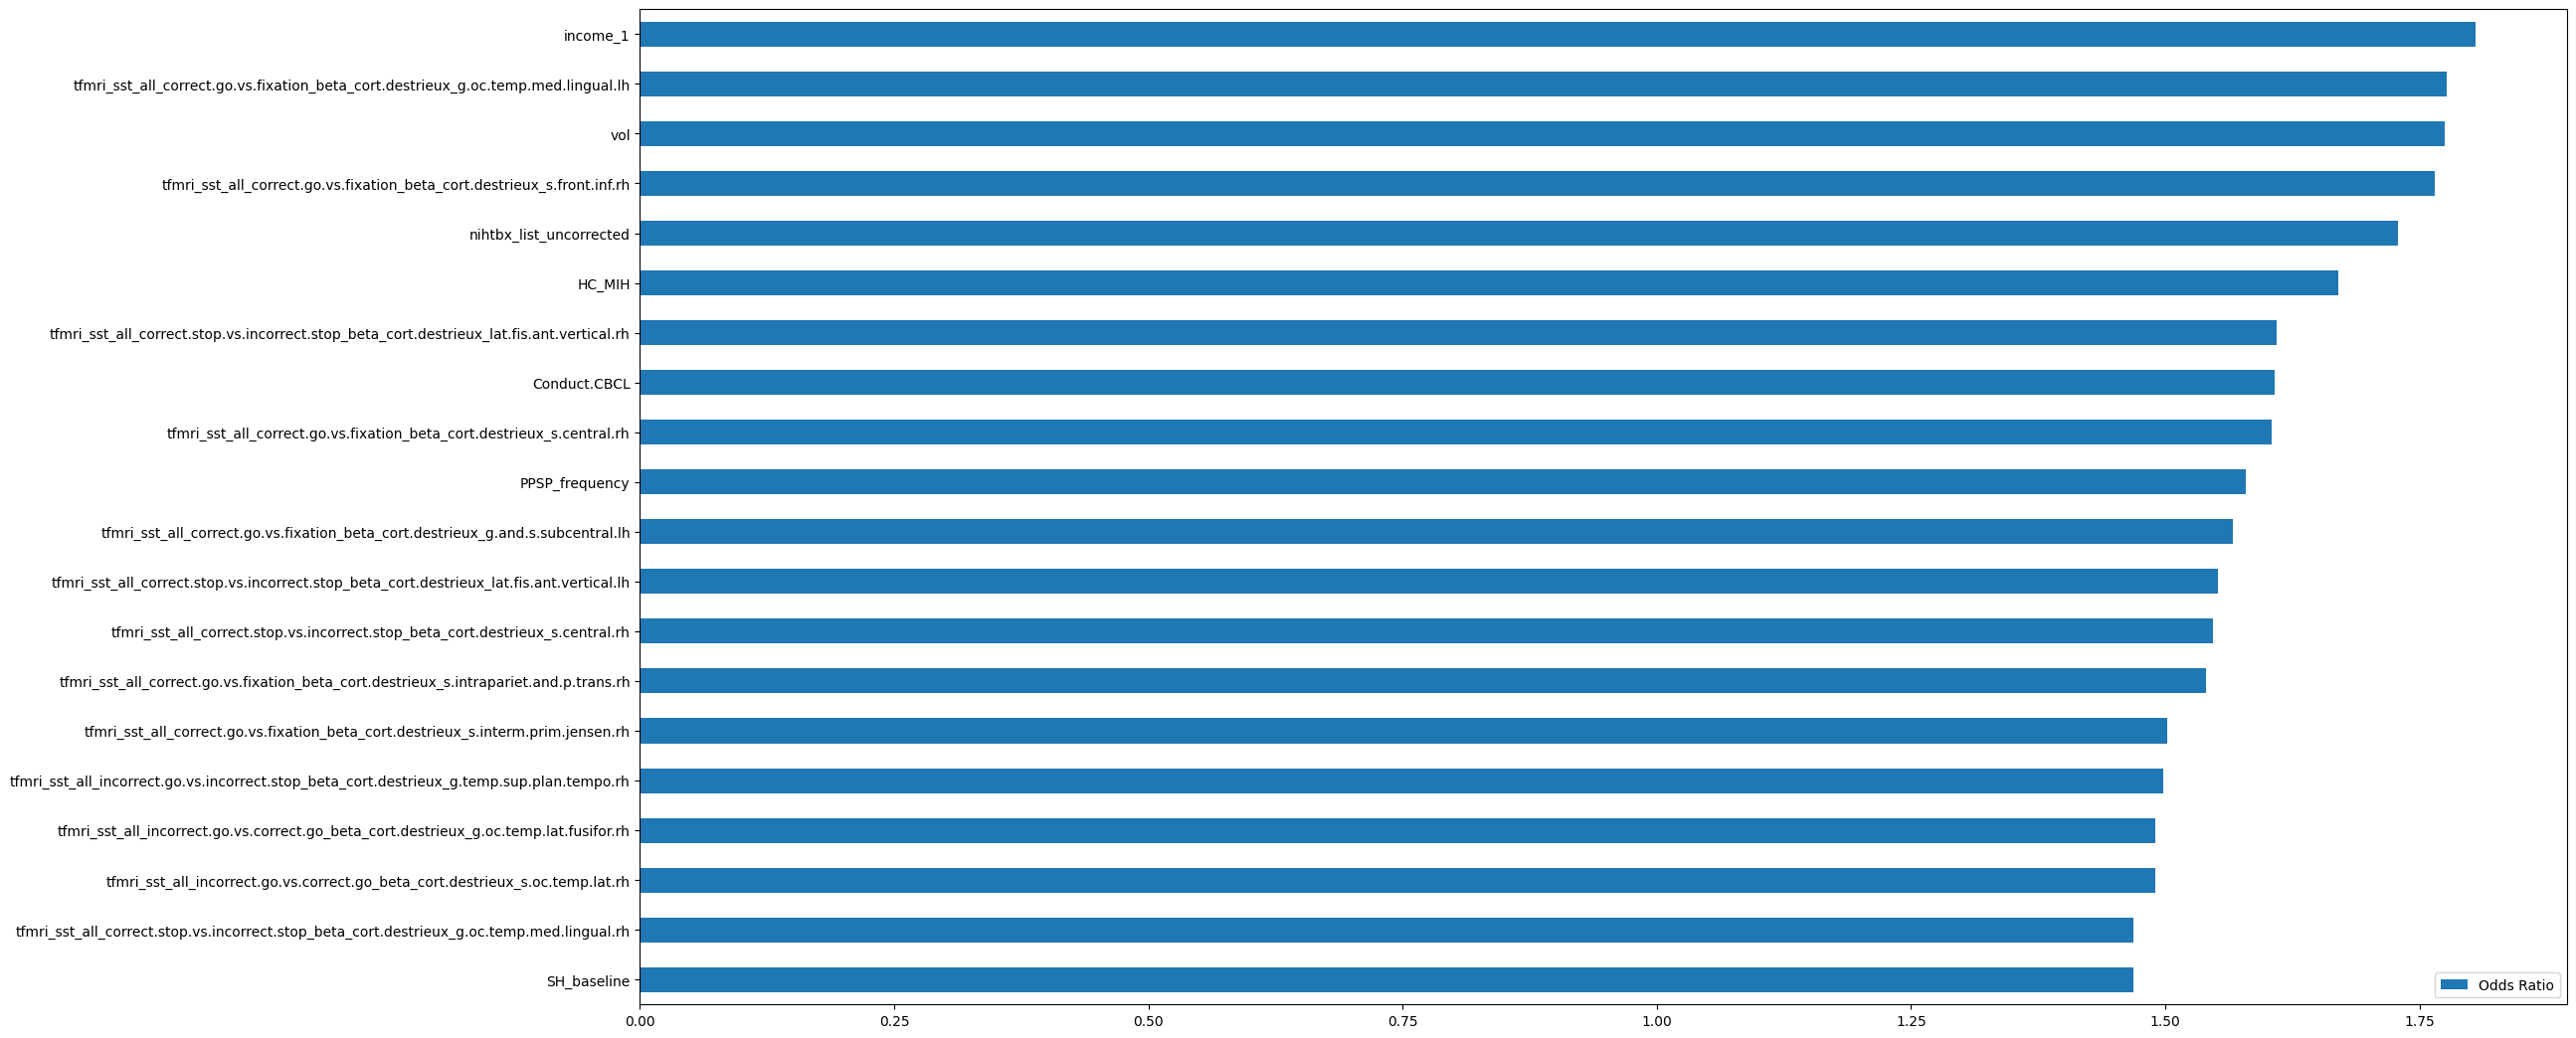

In [31]:
feature_odds = pd.DataFrame(odds_ratios, index=feature_names,
                            columns=['Odds Ratio'])
feature_odds = feature_odds.sort_values(by='Odds Ratio', ascending=False)
FI_plot = feature_odds.head(20).plot(figsize=(25,13), kind='barh').invert_yaxis()

## **Model Optimization: Method 1**

### **Trial 1: Param_C = 0.000695**

In [ ]:
param_grid = [
    {'penalty':['l1'],
    'C' : np.logspace(-4,4,20),
    'solver': ['liblinear'], # liblinear is for smaller datasets, saga for large
    'max_iter'  : [1000,2500,5000]}]

optimal_params = GridSearchCV(
    estimator=LogisticRegression(random_state=1, class_weight='balanced'),
    param_grid = param_grid,
    scoring = 'roc_auc',
    n_jobs=-1,
    cv=5,
    verbose=1)

optimal_params.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=1),
             n_jobs=-1,
             param_grid=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'max_iter': [1000, 2500, 5000], 'penalty': ['l1'],
                          'solver': ['liblinear']}],
             scoring='roc_auc', verbose=1)

In [ ]:
results_df = pd.DataFrame(optimal_params.cv_results_)

scoring_df = ['param_C', 'param_max_iter', 'mean_test_score', 'rank_test_score']
results_df = results_df[scoring_df]
sorted_df = results_df.sort_values(by=['rank_test_score'], ascending=False)
sorted_df.head(5)

,param_C,param_max_iter,mean_test_score,rank_test_score
6,0.000695,1000,0.457688,58
7,0.000695,2500,0.457688,58
8,0.000695,5000,0.457688,58
0,0.000100,1000,0.500000,52
1,0.000100,2500,0.500000,52


In [ ]:
log_reg = LogisticRegression(random_state=1, class_weight='balanced', max_iter=1000,
                              penalty='l1', solver='liblinear', C=0.000695)
log_reg1 = log_reg.fit(X_train, y_train)
get_metrics(X_valid, y_valid, log_reg1)
get_metrics(X_test, y_test, log_reg1)

              precision    recall  f1-score   support

           0       1.00      0.72      0.84      1089
           1       0.01      0.57      0.03         7

    accuracy                           0.72      1096
   macro avg       0.50      0.65      0.43      1096
weighted avg       0.99      0.72      0.83      1096

Accuracy: 0.7226
Recall: 0.5714
Sensitivity: 0.5714
Specificity: 0.7236
AUC: 0.7168
              precision    recall  f1-score   support

           0       0.50      0.64      0.56        11
           1       0.33      0.22      0.27         9

    accuracy                           0.45        20
   macro avg       0.42      0.43      0.41        20
weighted avg       0.42      0.45      0.43        20

Accuracy: 0.4500
Recall: 0.2222
Sensitivity: 0.2222
Specificity: 0.6364
AUC: 0.6667


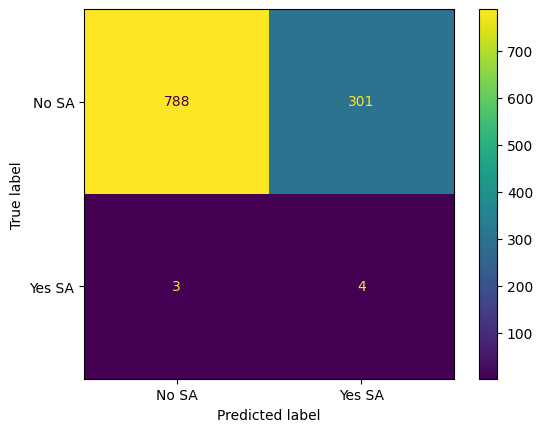

In [ ]:
ConfusionMatrixDisplay.from_estimator(log_reg1, X_valid, y_valid,
                                      display_labels=["No SA", "Yes SA"])

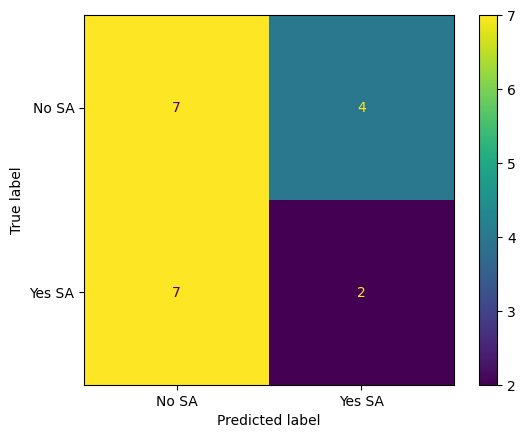

In [ ]:
ConfusionMatrixDisplay.from_estimator(log_reg1, X_test, y_test,
                                      display_labels=["No SA", "Yes SA"])

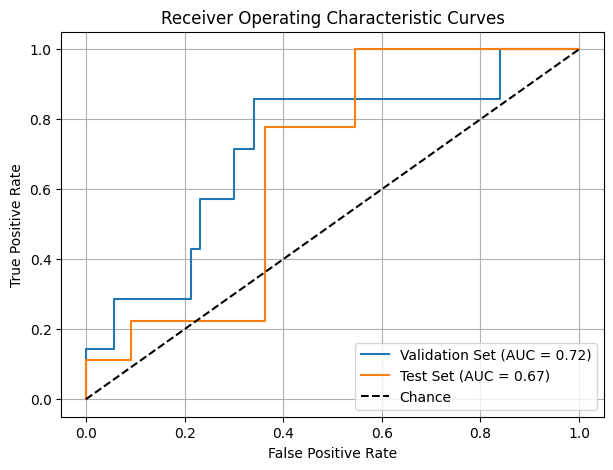

In [ ]:
predict_proba_v = log_reg1.predict_proba(X_valid)
predict_proba_t = log_reg1.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_valid, predict_proba_v[:,1])
fpr1, tpr1, thresholds1 = roc_curve(y_test, predict_proba_t[:,1])
auc_ = auc(fpr, tpr)
auc1 = auc(fpr1, tpr1)

#plot auc roc
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'Validation Set (AUC = {auc_:.2f})')
plt.plot(fpr1, tpr1, label=f'Test Set (AUC = {auc1:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curves')
plt.legend()
plt.grid(True)
plt.show()

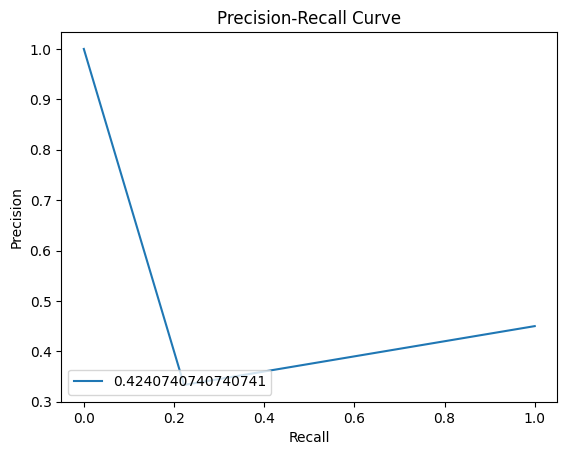

In [ ]:
y_pred = log_reg1.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision, label=average_precision_score(y_test, y_pred))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

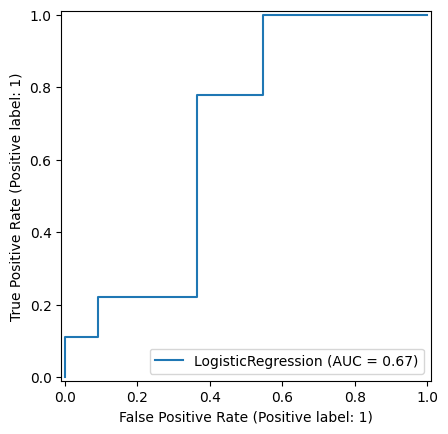

In [ ]:
RocCurveDisplay.from_estimator(log_reg1, X_test, y_test)

In [ ]:
feature_names = X_train.columns

# Coefficients and Odds Ratios
coef = log_reg1.coef_[0]
odds_ratios = np.exp(coef)

# Display feature importance using coefficients and odds ratios
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef,
    'Odds Ratio': odds_ratios
})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)
feature_importance.head(5)

,Feature,Coefficient,Odds Ratio
92,Aggressive.CBCL,0.006248,1.006267
257,tfmri_sst_all_correct.go.vs.fixation_beta_cort...,0.002107,1.002109
800,tfmri_sst_all_correct.stop.vs.incorrect.stop_b...,0.000000,1.000000
775,tfmri_sst_all_correct.stop.vs.incorrect.stop_b...,0.000000,1.000000
781,tfmri_sst_all_correct.stop.vs.incorrect.stop_b...,0.000000,1.000000


### **Trial 2: Param_C = 0.000873**

#### Visualizing c_values

In [ ]:
c_values = np.arange(0.000680, 0.0009, 0.000001)

param_grid = [
    {'C' : c_values,
    'max_iter'  : [2500]}]

optimal_params = GridSearchCV(
    estimator=LogisticRegression(random_state=1, class_weight='balanced', penalty='l1', solver='liblinear'),
    param_grid = param_grid,
    scoring = ['roc_auc', 'recall', 'average_precision'],
    n_jobs=-1,
    cv=5,
    verbose=1,
    refit = 'roc_auc')

optimal_params.fit(X_train, y_train)

Fitting 5 folds for each of 220 candidates, totalling 1100 fits


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced', penalty='l1',
                                          random_state=1, solver='liblinear'),
             n_jobs=-1,
             param_grid=[{'C': array([0.00068 , 0.000681, 0.000682, 0.000683, 0.000684, 0.000685,
       0.000686, 0.000687, 0.000688, 0.000689, 0.00069 , 0.000691,
       0.000692, 0.000693, 0.000694, 0.000695, 0.000696, 0.000697,
       0.000698, 0.000699, 0.0007  , 0.000701, 0.0...
       0.000866, 0.000867, 0.000868, 0.000869, 0.00087 , 0.000871,
       0.000872, 0.000873, 0.000874, 0.000875, 0.000876, 0.000877,
       0.000878, 0.000879, 0.00088 , 0.000881, 0.000882, 0.000883,
       0.000884, 0.000885, 0.000886, 0.000887, 0.000888, 0.000889,
       0.00089 , 0.000891, 0.000892, 0.000893, 0.000894, 0.000895,
       0.000896, 0.000897, 0.000898, 0.000899]),
                          'max_iter': [2500]}],
             refit='roc_auc',
             scoring=['roc_auc', 'recall', 'average_precision'], verbose=1)

In [ ]:
results_df = pd.DataFrame(optimal_params.cv_results_)

scoring_df = ['param_C', 'mean_test_roc_auc', 'mean_test_average_precision', 'mean_test_recall']
results_df = results_df[scoring_df]
sorted_df = results_df.sort_values(by=['mean_test_roc_auc'], ascending=False)
sorted_df.head(5)

,param_C,mean_test_roc_auc,mean_test_average_precision,mean_test_recall
219,0.000899,0.642841,0.021350,0.5
218,0.000898,0.642573,0.021357,0.5
217,0.000897,0.642381,0.021343,0.5
216,0.000896,0.642151,0.021312,0.5
215,0.000895,0.641998,0.021327,0.5


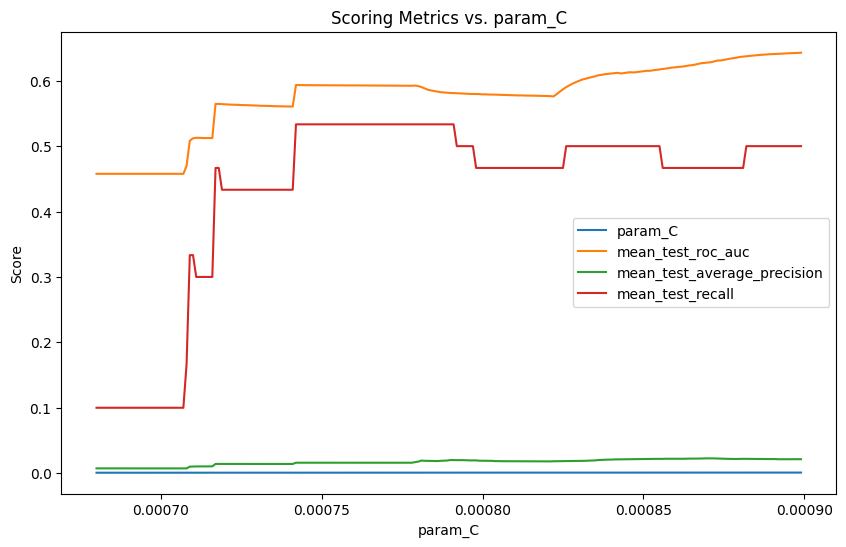

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

for metric in scoring_df:
    ax.plot(results_df['param_C'], results_df[metric], label=metric)

ax.set_xlabel('param_C')
ax.set_ylabel('Score')
ax.set_title('Scoring Metrics vs. param_C')
ax.legend()
plt.show()

In [ ]:
recall = []
auc_valid = []
auc_test = []

for c in results_df['param_C']:
  log_reg = LogisticRegression(random_state=1, class_weight='balanced', max_iter=2500,
                              penalty='l1', solver='liblinear', C=c)
  log_reg = log_reg.fit(X_train, y_train)
  y_pred = log_reg.predict(X_test)
  y_proba_v = log_reg.predict_proba(X_valid)[:,1]
  y_proba_t = log_reg.predict_proba(X_test)[:,1]

  recall.append(recall_score(y_test, y_pred))
  auc_valid.append(roc_auc_score(y_valid, y_proba_v))
  auc_test.append(roc_auc_score(y_test, y_proba_t))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  

In [ ]:
metrics = ['auc_valid', 'auc_test', 'recall']
metrics_df = pd.DataFrame({'param_C': results_df['param_C'], 'auc_valid': auc_valid, 'auc_test': auc_test, 'recall': recall})

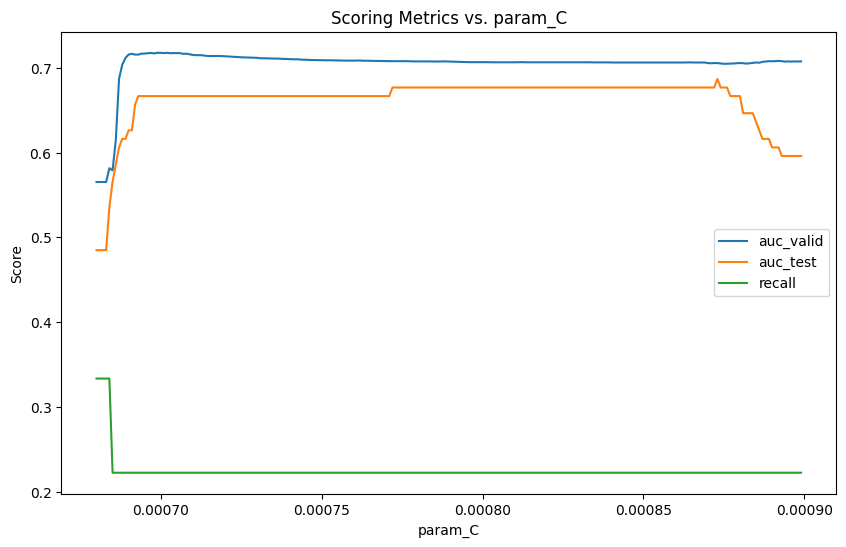

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

for metric in metrics:
    ax.plot(results_df['param_C'], metrics_df[metric], label=metric) # Access column by index

ax.set_xlabel('param_C')
ax.set_ylabel('Score')
ax.set_title('Scoring Metrics vs. param_C')
ax.legend()
plt.show()

In [ ]:
metrics_df.sort_values(by=['auc_test'], ascending=False).head(5)

,param_C,auc_valid,auc_test,recall
193,0.000873,0.705628,0.686869,0.222222
110,0.000790,0.707333,0.676768,0.222222
134,0.000814,0.706546,0.676768,0.222222
125,0.000805,0.706546,0.676768,0.222222
126,0.000806,0.706546,0.676768,0.222222


#### Model Building

In [ ]:
log_reg = LogisticRegression(random_state=1, class_weight='balanced', max_iter=2500,
                              penalty='l1', solver='liblinear', C=0.000873)
log_reg2 = log_reg.fit(X_train, y_train)
get_metrics(X_valid, y_valid, log_reg2)
get_metrics(X_test, y_test, log_reg2)

              precision    recall  f1-score   support

           0       1.00      0.74      0.85      1089
           1       0.01      0.57      0.03         7

    accuracy                           0.74      1096
   macro avg       0.51      0.66      0.44      1096
weighted avg       0.99      0.74      0.84      1096

Accuracy: 0.7381
Recall: 0.5714
Sensitivity: 0.5714
Specificity: 0.7392
AUC: 0.7056
              precision    recall  f1-score   support

           0       0.53      0.73      0.62        11
           1       0.40      0.22      0.29         9

    accuracy                           0.50        20
   macro avg       0.47      0.47      0.45        20
weighted avg       0.47      0.50      0.47        20

Accuracy: 0.5000
Recall: 0.2222
Sensitivity: 0.2222
Specificity: 0.7273
AUC: 0.6869


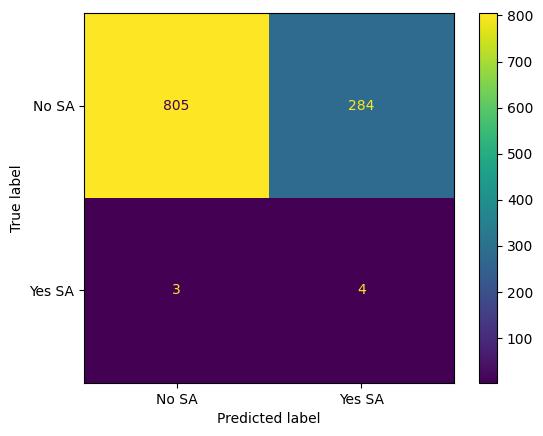

In [ ]:
ConfusionMatrixDisplay.from_estimator(log_reg2, X_valid, y_valid,
                                      display_labels=["No SA", "Yes SA"])

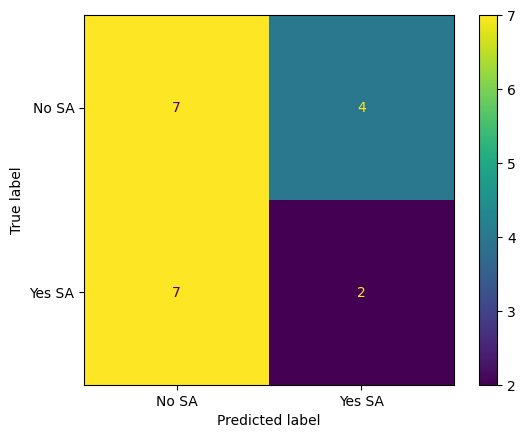

In [ ]:
ConfusionMatrixDisplay.from_estimator(log_reg1, X_test, y_test,
                                      display_labels=["No SA", "Yes SA"])

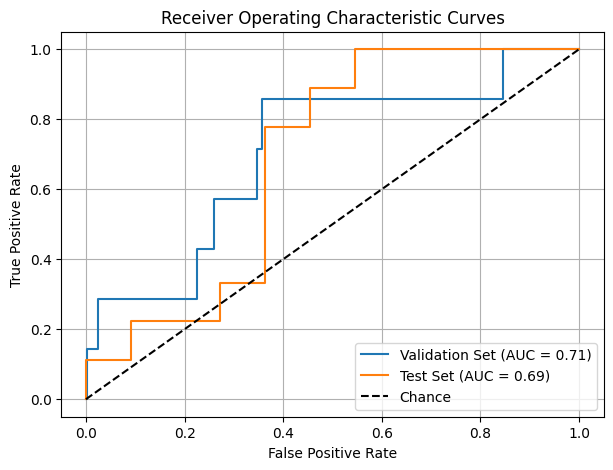

In [ ]:
predict_proba_v = log_reg2.predict_proba(X_valid)
predict_proba_t = log_reg2.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_valid, predict_proba_v[:,1])
fpr2, tpr2, thresholds2 = roc_curve(y_test, predict_proba_t[:,1])
auc_ = auc(fpr, tpr)
auc2 = auc(fpr2, tpr2)

#plot auc roc
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'Validation Set (AUC = {auc_:.2f})')
plt.plot(fpr2, tpr2, label=f'Test Set (AUC = {auc2:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curves')
plt.legend()
plt.grid(True)
plt.show()

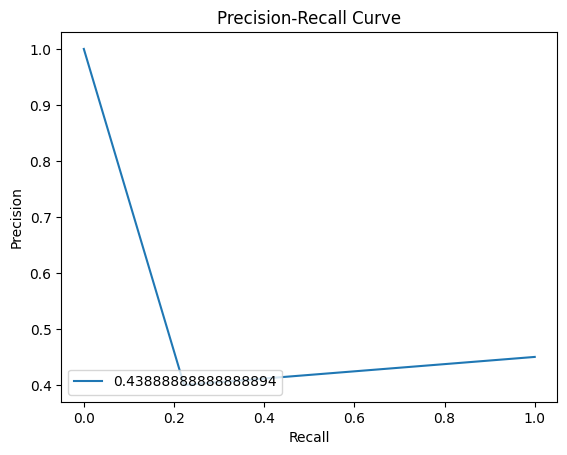

In [ ]:
y_pred = log_reg2.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision, label=average_precision_score(y_test, y_pred))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

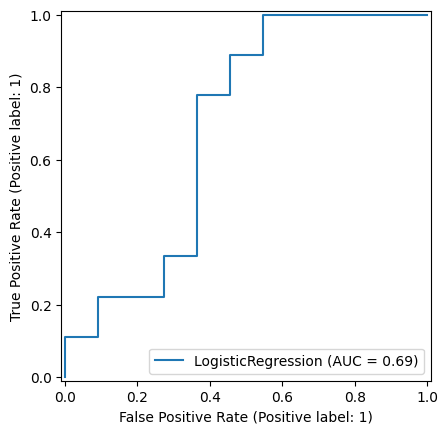

In [ ]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(log_reg2, X_test, y_test)

In [ ]:
feature_names = X_train.columns

# Coefficients and Odds Ratios
coef = log_reg1.coef_[0]
odds_ratios = np.exp(coef)

# Display feature importance using coefficients and odds ratios
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef,
    'Odds Ratio': odds_ratios
})
# feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)
# feature_importance.head(5)

### **Trial 3: Param_C = 0.000790**

In [ ]:
log_reg = LogisticRegression(random_state=1, class_weight='balanced', max_iter=2500,
                              penalty='l1', solver='liblinear', C=0.000790)
log_reg3 = log_reg.fit(X_train, y_train)
get_metrics(X_valid, y_valid, log_reg3)
get_metrics(X_test, y_test, log_reg3)

              precision    recall  f1-score   support

           0       1.00      0.74      0.85      1089
           1       0.01      0.57      0.03         7

    accuracy                           0.74      1096
   macro avg       0.51      0.65      0.44      1096
weighted avg       0.99      0.74      0.84      1096

Accuracy: 0.7354
Recall: 0.5714
Sensitivity: 0.5714
Specificity: 0.7365
AUC: 0.7073
              precision    recall  f1-score   support

           0       0.53      0.73      0.62        11
           1       0.40      0.22      0.29         9

    accuracy                           0.50        20
   macro avg       0.47      0.47      0.45        20
weighted avg       0.47      0.50      0.47        20

Accuracy: 0.5000
Recall: 0.2222
Sensitivity: 0.2222
Specificity: 0.7273
AUC: 0.6768


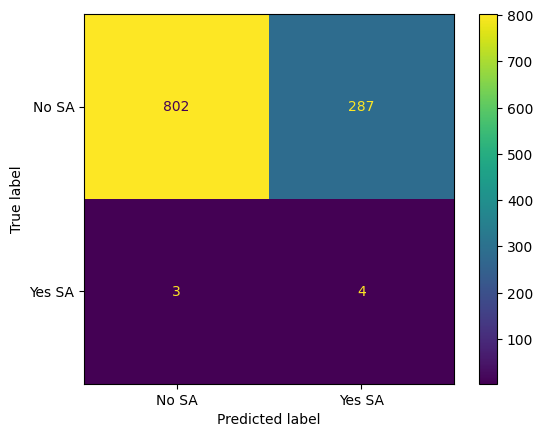

In [ ]:
ConfusionMatrixDisplay.from_estimator(log_reg3, X_valid, y_valid,
                                      display_labels=["No SA", "Yes SA"])

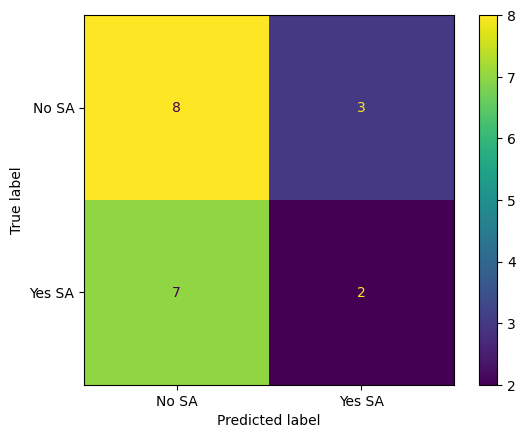

In [ ]:
ConfusionMatrixDisplay.from_estimator(log_reg3, X_test, y_test,
                                      display_labels=["No SA", "Yes SA"])

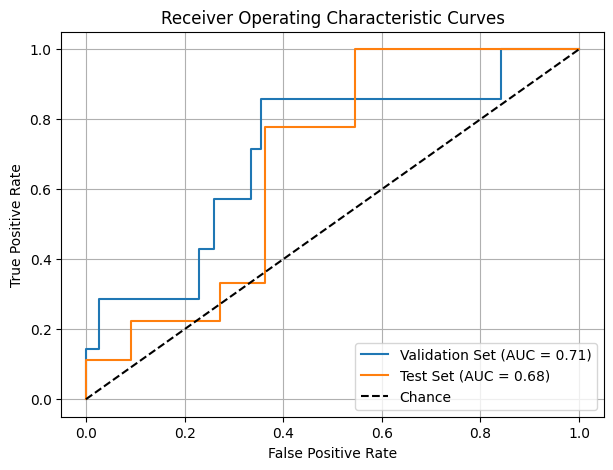

In [ ]:
predict_proba_v = log_reg3.predict_proba(X_valid)
predict_proba_t = log_reg3.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_valid, predict_proba_v[:,1])
fpr3, tpr3, thresholds3 = roc_curve(y_test, predict_proba_t[:,1])
auc_ = auc(fpr, tpr)
auc3 = auc(fpr3, tpr3)

#plot auc roc
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'Validation Set (AUC = {auc_:.2f})')
plt.plot(fpr3, tpr3, label=f'Test Set (AUC = {auc3:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curves')
plt.legend()
plt.grid(True)
plt.show()

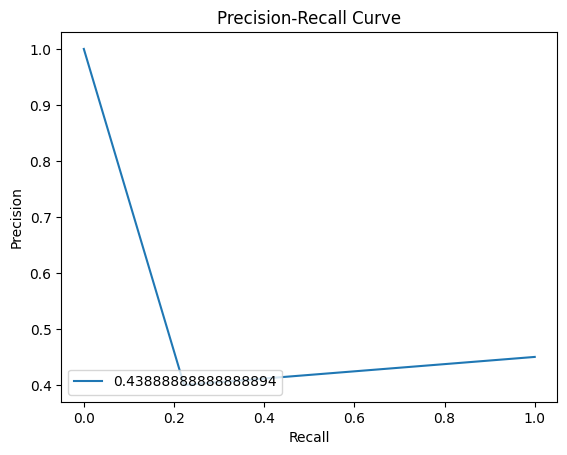

In [ ]:
y_pred = log_reg3.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision, label=average_precision_score(y_test, y_pred))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

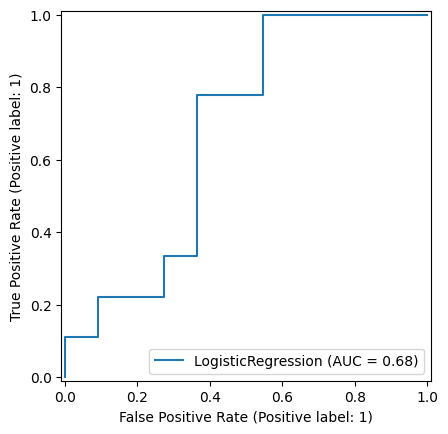

In [ ]:
RocCurveDisplay.from_estimator(log_reg3, X_test, y_test)

In [ ]:
feature_names = X_train.columns

# Coefficients and Odds Ratios
coef = log_reg1.coef_[0]
odds_ratios = np.exp(coef)

# Display feature importance using coefficients and odds ratios
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef,
    'Odds Ratio': odds_ratios
})
# feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)
# feature_importance.head(5)

## **Model Optimization: Method 2**

### **Iteration of Param_C**

#### 0 to 1 (step size = 0.001)

In [ ]:
c_values = np.arange(0.000000001, 1, 0.001) # run-time was 50 m

recall = []
auc_valid = []
auc_test = []
auprc = []

iteration_helper(c_values)

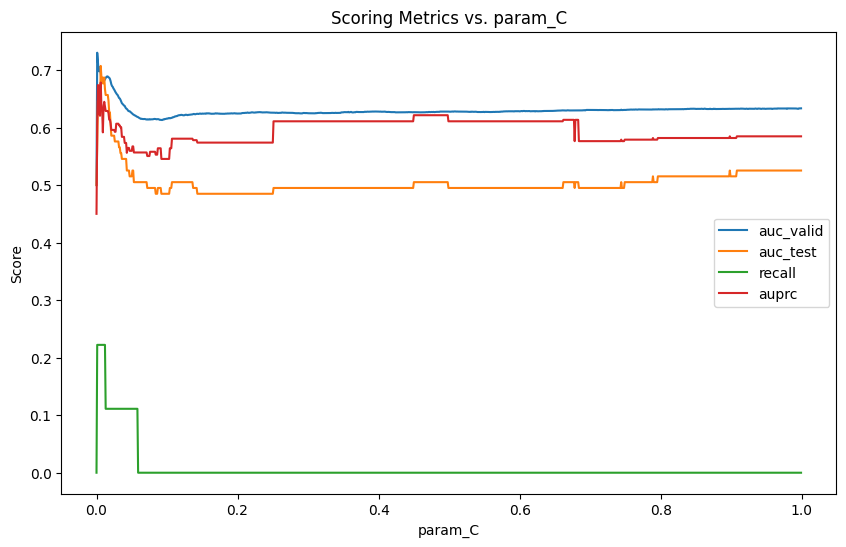

In [ ]:
metrics = ['auc_valid', 'auc_test', 'recall', 'auprc']
metrics_df = pd.DataFrame({'param_C': c_values, 'auc_valid': auc_valid, 'auc_test': auc_test, 'recall': recall, 'auprc': auprc})

fig, ax = plt.subplots(figsize=(10, 6))

for metric in metrics:
    ax.plot(metrics_df['param_C'], metrics_df[metric], label=metric) # Access column by index

ax.set_xlabel('param_C')
ax.set_ylabel('Score')
ax.set_title('Scoring Metrics vs. param_C')
ax.legend()
plt.show()

In [ ]:
metrics_df.sort_values(by=['auc_test'], ascending=False).head(5)

,param_C,auc_valid,auc_test,recall,auprc
6,0.006,0.694084,0.707071,0.222222,0.678247
11,0.011,0.681490,0.686869,0.222222,0.644684
9,0.009,0.679785,0.686869,0.222222,0.591590
7,0.007,0.681097,0.686869,0.222222,0.633494
8,0.008,0.677948,0.676768,0.222222,0.632502


#### 0.0001 to 0.02 (step size = 0.0001)

In [ ]:
c_values = np.arange(0.0001, 0.02, 0.0001) # run-time was 4min

recall = []
auc_valid = []
auc_test = []
auprc = []

iteration_helper(c_values)

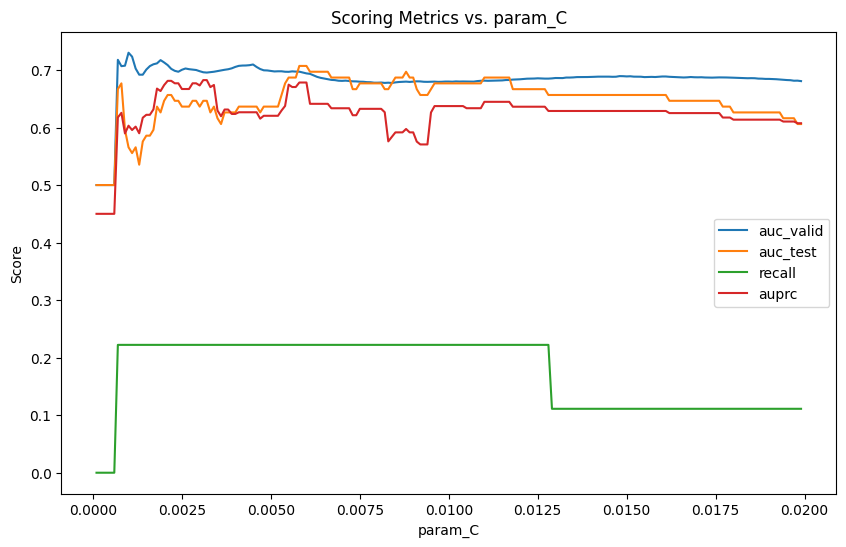

In [ ]:
metrics = ['auc_valid', 'auc_test', 'recall', 'auprc']
metrics_df = pd.DataFrame({'param_C': c_values, 'auc_valid': auc_valid, 'auc_test': auc_test, 'recall': recall, 'auprc': auprc})

fig, ax = plt.subplots(figsize=(10, 6))

for metric in metrics:
    ax.plot(metrics_df['param_C'], metrics_df[metric], label=metric) # Access column by index

ax.set_xlabel('param_C')
ax.set_ylabel('Score')
ax.set_title('Scoring Metrics vs. param_C')
ax.legend()
plt.show()

In [ ]:
metrics_df.sort_values(by=['auc_test'], ascending=False).head(5)

,param_C,auc_valid,auc_test,recall,auprc
57,0.0058,0.697101,0.707071,0.222222,0.678247
58,0.0059,0.695527,0.707071,0.222222,0.678247
59,0.0060,0.694084,0.707071,0.222222,0.678247
61,0.0062,0.690673,0.696970,0.222222,0.641210
64,0.0065,0.685163,0.696970,0.222222,0.641210


In [ ]:
metrics_df.sort_values(by=['recall'], ascending=False).head(5)

,param_C,auc_valid,auc_test,recall,auprc
6,0.0007,0.717696,0.666667,0.222222,0.617621
12,0.0013,0.691854,0.535354,0.222222,0.590030
11,0.0012,0.702479,0.565657,0.222222,0.601617
10,0.0011,0.723206,0.555556,0.222222,0.595664
9,0.0010,0.730028,0.565657,0.222222,0.603175


In [ ]:
metrics_df.sort_values(by=['auprc'], ascending=False).head(5)

,param_C,auc_valid,auc_test,recall,auprc
31,0.0032,0.695527,0.646465,0.222222,0.682432
30,0.0031,0.696051,0.646465,0.222222,0.682432
20,0.0021,0.708514,0.656566,0.222222,0.681150
21,0.0022,0.701955,0.656566,0.222222,0.681150
57,0.0058,0.697101,0.707071,0.222222,0.678247


### Manual Testing

In [32]:
c_values = sorted([0.0058, 0.0059, 0.006, 0.0065, 0.0062, 0.0007, 0.001, 0.0011, 0.0012, 0.0013, 0.0032, 0.0031, 0.0021, 0.0022])

# print(c_values)

c_values_1 = [0.0007, 0.001, 0.0011, 0.0012, 0.0013, 0.0021, 0.0022, 0.0031, 0.0032]
c_values_2 = [0.0058, 0.0059, 0.006, 0.0062, 0.0065]

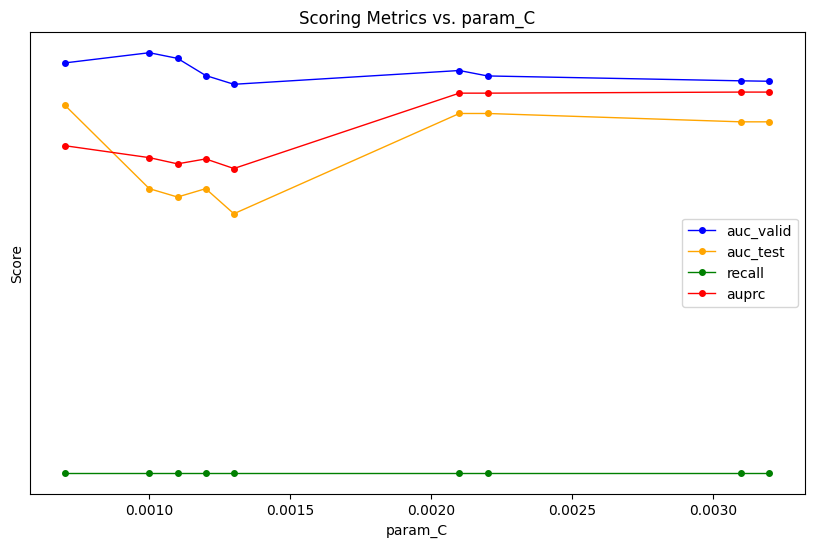

In [33]:
recall = []
auc_valid = []
auc_test = []
auprc = []

iteration_helper(c_values_1)

mean_metrics = []
for i in range(len(recall)):
  mean_metrics.append(np.mean([recall[i], auc_valid[i], auc_test[i], auprc[i]]))

metrics = ['auc_valid', 'auc_test', 'recall', 'auprc']
metrics_df_1 = pd.DataFrame({'param_C': c_values_1, 'auc_valid': auc_valid,
                           'auc_test': auc_test, 'recall': recall, 'auprc': auprc, 'mean': mean_metrics})

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['blue', 'orange', 'green', 'red']

for i in range(len(metrics)):
    ax.plot(metrics_df_1['param_C'], metrics_df_1[metrics[i]], color=colors[i],
            marker='o', linewidth=1, markersize=4, label=metrics[i])

ax.set_xlabel('param_C')
ax.set_ylabel('Score')
ax.set_yticks([])
ax.set_title('Scoring Metrics vs. param_C')
ax.legend()
plt.show()

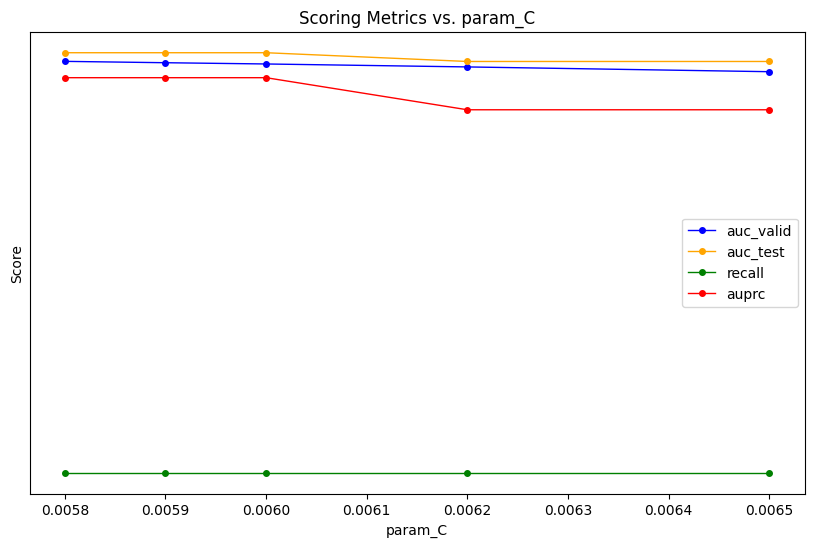

In [34]:
recall = []
auc_valid = []
auc_test = []
auprc = []

iteration_helper(c_values_2)

mean_metrics = []
for i in range(len(recall)):
  mean_metrics.append(np.mean([recall[i], auc_valid[i], auc_test[i], auprc[i]]))

metrics = ['auc_valid', 'auc_test', 'recall', 'auprc']
metrics_df_2 = pd.DataFrame({'param_C': c_values_2, 'auc_valid': auc_valid,
                           'auc_test': auc_test, 'recall': recall, 'auprc': auprc, 'mean': mean_metrics})

fig, ax = plt.subplots(figsize=(10, 6))

colors = ['blue', 'orange', 'green', 'red']

for i in range(len(metrics)):
    ax.plot(metrics_df_2['param_C'], metrics_df_2[metrics[i]], color=colors[i],
            marker='o', linewidth=1, markersize=4, label=metrics[i])

ax.set_xlabel('param_C')
ax.set_ylabel('Score')
ax.set_yticks([])
ax.set_title('Scoring Metrics vs. param_C')
ax.legend()
plt.show()

In [44]:
metrics_df = pd.concat([metrics_df_1, metrics_df_2], axis=0)
metrics_df.sort_values(by=['mean'], ascending=False).head(5)

,param_C,auc_valid,auc_test,recall,auprc,mean
0,0.0058,0.697101,0.707071,0.222222,0.678247,0.576160
1,0.0059,0.695527,0.707071,0.222222,0.678247,0.575767
2,0.0060,0.694084,0.707071,0.222222,0.678247,0.575406
5,0.0021,0.708514,0.656566,0.222222,0.681150,0.567113
6,0.0022,0.701955,0.656566,0.222222,0.681150,0.565473


In [38]:
metrics_df.sort_values(by=['auc_test'], ascending=False).head(5)

,param_C,auc_valid,auc_test,recall,auprc,mean
1,0.0059,0.695527,0.707071,0.222222,0.678247,0.575767
0,0.0058,0.697101,0.707071,0.222222,0.678247,0.576160
2,0.0060,0.694084,0.707071,0.222222,0.678247,0.575406
3,0.0062,0.690673,0.696970,0.222222,0.641210,0.562769
4,0.0065,0.685163,0.696970,0.222222,0.641210,0.561391


In [39]:
metrics_df.sort_values(by=['recall'], ascending=False).head(5)

,param_C,auc_valid,auc_test,recall,auprc,mean
0,0.0007,0.717696,0.666667,0.222222,0.617621,0.556051
1,0.0010,0.730028,0.565657,0.222222,0.603175,0.530270
2,0.0011,0.723206,0.555556,0.222222,0.595664,0.524162
3,0.0012,0.702479,0.565657,0.222222,0.601617,0.522994
4,0.0013,0.691854,0.535354,0.222222,0.590030,0.509865


In [46]:
metrics_df.sort_values(by=['auprc'], ascending=False).head(5)

,param_C,auc_valid,auc_test,recall,auprc,mean
8,0.0032,0.695527,0.646465,0.222222,0.682432,0.561661
7,0.0031,0.696051,0.646465,0.222222,0.682432,0.561793
5,0.0021,0.708514,0.656566,0.222222,0.681150,0.567113
6,0.0022,0.701955,0.656566,0.222222,0.681150,0.565473
0,0.0058,0.697101,0.707071,0.222222,0.678247,0.576160


In [45]:
metrics_df.sort_values(by=['auc_valid'], ascending=False).head(5)

,param_C,auc_valid,auc_test,recall,auprc,mean
1,0.0010,0.730028,0.565657,0.222222,0.603175,0.530270
2,0.0011,0.723206,0.555556,0.222222,0.595664,0.524162
0,0.0007,0.717696,0.666667,0.222222,0.617621,0.556051
5,0.0021,0.708514,0.656566,0.222222,0.681150,0.567113
3,0.0012,0.702479,0.565657,0.222222,0.601617,0.522994


## **Trials**


*   For best auc_test, 0.0059, 0.0058, 0.0060
*   For best auprc, 0.0032, 0.0031, 0.0021
*   For best recall, 0.0007, 0.0010, 0.0011
*   For best mean, 0.0058, 0.0059, 0.0060

### Best auc_test + mean: 0.0059, 0.0058, 0.0060

In [87]:
log_reg = LogisticRegression(random_state=1, class_weight='balanced', max_iter=2500,
                            penalty='l1', solver='liblinear',
                            C=0.0058)
log_reg1 = log_reg.fit(X_train, y_train)
get_metrics(X_valid, y_valid, log_reg1)
get_metrics(X_test, y_test, log_reg1)

              precision    recall  f1-score   support

           0       1.00      0.85      0.92      1089
           1       0.02      0.43      0.03         7

    accuracy                           0.84      1096
   macro avg       0.51      0.64      0.47      1096
weighted avg       0.99      0.84      0.91      1096

Accuracy: 0.8449
Recall: 0.4286
Sensitivity: 0.4286
Specificity: 0.8476
AUC: 0.6971
Average Precision: 0.0282
              precision    recall  f1-score   support

           0       0.59      0.91      0.71        11
           1       0.67      0.22      0.33         9

    accuracy                           0.60        20
   macro avg       0.63      0.57      0.52        20
weighted avg       0.62      0.60      0.54        20

Accuracy: 0.6000
Recall: 0.2222
Sensitivity: 0.2222
Specificity: 0.9091
AUC: 0.7071
Average Precision: 0.6782


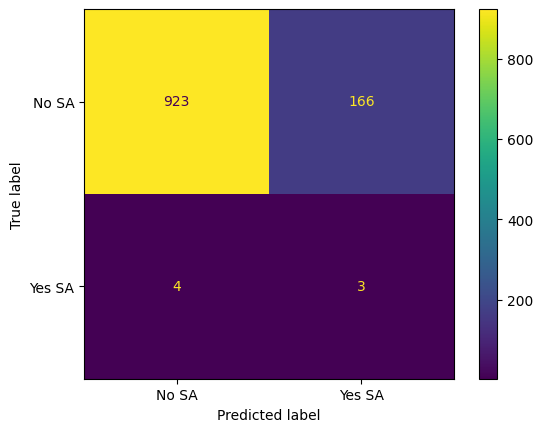

In [88]:
ConfusionMatrixDisplay.from_estimator(log_reg1, X_valid, y_valid,
                                      display_labels=["No SA", "Yes SA"])

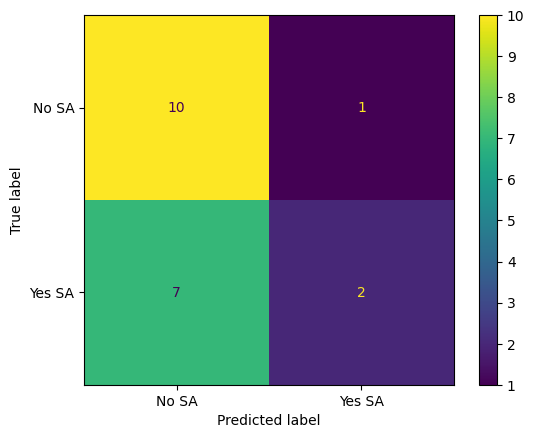

In [89]:
ConfusionMatrixDisplay.from_estimator(log_reg1, X_test, y_test,
                                      display_labels=["No SA", "Yes SA"])

### Best auprc: 0.0032, 0.0031, 0.0021

In [111]:
log_reg = LogisticRegression(random_state=1, class_weight='balanced', max_iter=2500,
                            penalty='l1', solver='liblinear',
                            C=0.0021)
log_reg2 = log_reg.fit(X_train, y_train)
get_metrics(X_valid, y_valid, log_reg2)
get_metrics(X_test, y_test, log_reg2)

              precision    recall  f1-score   support

           0       1.00      0.80      0.89      1089
           1       0.01      0.43      0.03         7

    accuracy                           0.80      1096
   macro avg       0.50      0.62      0.46      1096
weighted avg       0.99      0.80      0.88      1096

Accuracy: 0.8002
Recall: 0.4286
Sensitivity: 0.4286
Specificity: 0.8026
AUC: 0.7085
Average Precision: 0.0332
              precision    recall  f1-score   support

           0       0.56      0.82      0.67        11
           1       0.50      0.22      0.31         9

    accuracy                           0.55        20
   macro avg       0.53      0.52      0.49        20
weighted avg       0.53      0.55      0.51        20

Accuracy: 0.5500
Recall: 0.2222
Sensitivity: 0.2222
Specificity: 0.8182
AUC: 0.6566
Average Precision: 0.6812


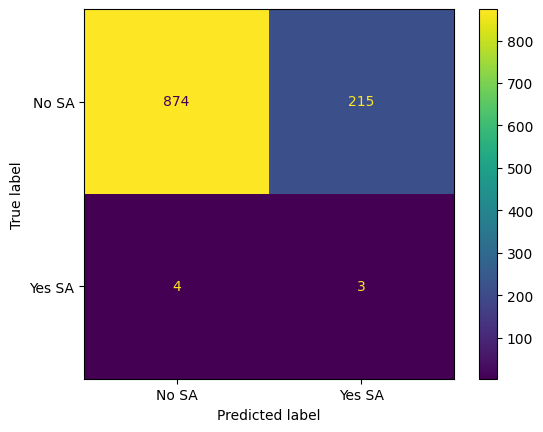

In [112]:
ConfusionMatrixDisplay.from_estimator(log_reg2, X_valid, y_valid,
                                      display_labels=["No SA", "Yes SA"])

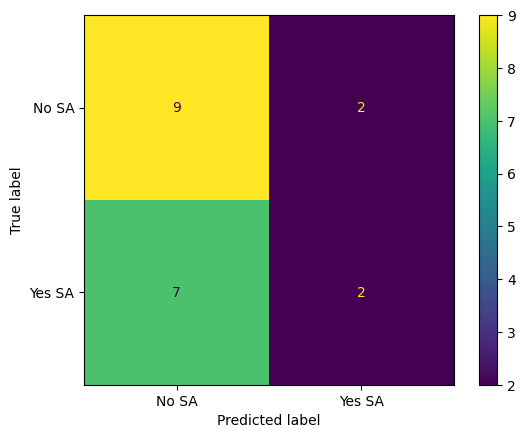

In [113]:
ConfusionMatrixDisplay.from_estimator(log_reg2, X_test, y_test,
                                      display_labels=["No SA", "Yes SA"])

### Best recall: 0.0007, 0.0010, 0.0011

In [126]:
log_reg = LogisticRegression(random_state=1, class_weight='balanced', max_iter=2500,
                            penalty='l1', solver='liblinear',
                            C=0.0007)
log_reg3 = log_reg.fit(X_train, y_train)
get_metrics(X_valid, y_valid, log_reg3)
get_metrics(X_test, y_test, log_reg3)

              precision    recall  f1-score   support

           0       1.00      0.73      0.84      1089
           1       0.01      0.57      0.03         7

    accuracy                           0.73      1096
   macro avg       0.50      0.65      0.43      1096
weighted avg       0.99      0.73      0.84      1096

Accuracy: 0.7272
Recall: 0.5714
Sensitivity: 0.5714
Specificity: 0.7282
AUC: 0.7177
Average Precision: 0.0869
              precision    recall  f1-score   support

           0       0.50      0.64      0.56        11
           1       0.33      0.22      0.27         9

    accuracy                           0.45        20
   macro avg       0.42      0.43      0.41        20
weighted avg       0.42      0.45      0.43        20

Accuracy: 0.4500
Recall: 0.2222
Sensitivity: 0.2222
Specificity: 0.6364
AUC: 0.6667
Average Precision: 0.6176


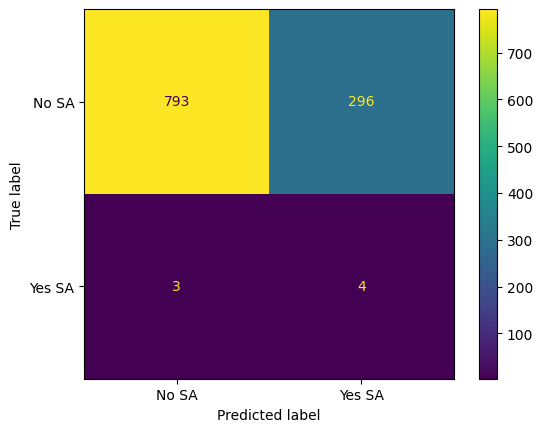

In [127]:
ConfusionMatrixDisplay.from_estimator(log_reg3, X_valid, y_valid,
                                      display_labels=["No SA", "Yes SA"])

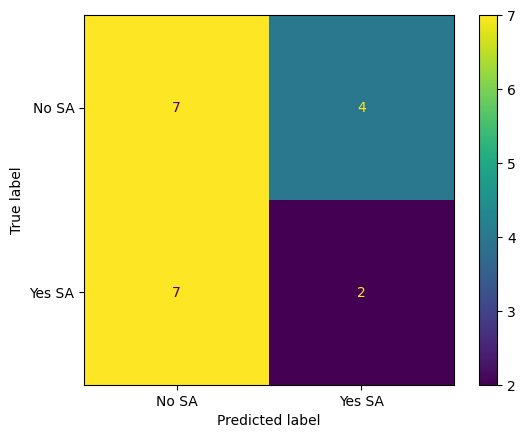

In [128]:
ConfusionMatrixDisplay.from_estimator(log_reg3, X_test, y_test,
                                      display_labels=["No SA", "Yes SA"])

## **Trial Conclusion: c = 0.0058**

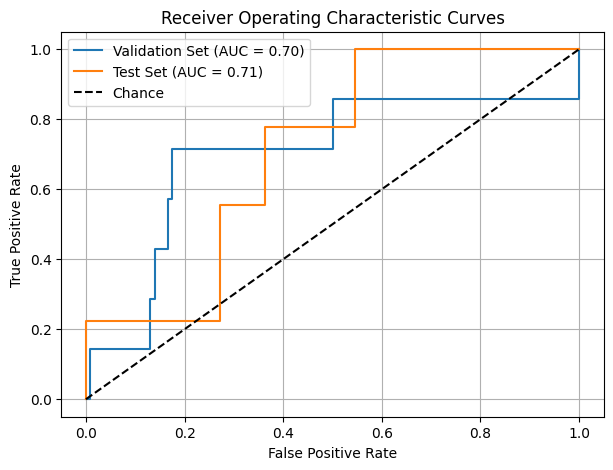

In [131]:
predict_proba_v = log_reg1.predict_proba(X_valid)
predict_proba_t = log_reg1.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_valid, predict_proba_v[:,1])
fpr1, tpr1, thresholds1 = roc_curve(y_test, predict_proba_t[:,1])
auc_ = auc(fpr, tpr)
auc1 = auc(fpr1, tpr1)

#plot auc roc
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'Validation Set (AUC = {auc_:.2f})')
plt.plot(fpr1, tpr1, label=f'Test Set (AUC = {auc1:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curves')
plt.legend()
plt.grid(True)
plt.show()

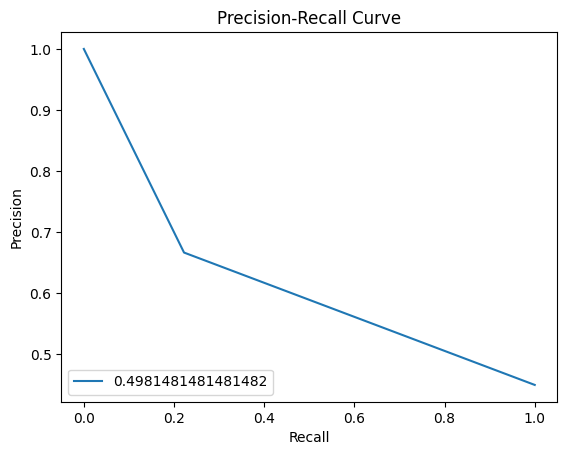

In [137]:
y_pred = log_reg1.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

plt.plot(recall, precision, label=average_precision_score(y_test, y_pred))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [138]:
feature_names = X_train.columns

# Coefficients and Odds Ratios
coef = log_reg1.coef_[0]
odds_ratios = np.exp(coef)

# Display feature importance using coefficients and odds ratios
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef,
    'Odds Ratio': odds_ratios
})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)
feature_importance.head(5)

,Feature,Coefficient,Odds Ratio
128,PPSP_frequency,0.398549,1.489662
101,Conduct.CBCL,0.394604,1.483796
86,WithDep.CBCL,0.324369,1.383158
70,nihtbx_list_uncorrected,0.153375,1.165762
255,tfmri_sst_all_correct.go.vs.fixation_beta_cort...,0.148884,1.160539


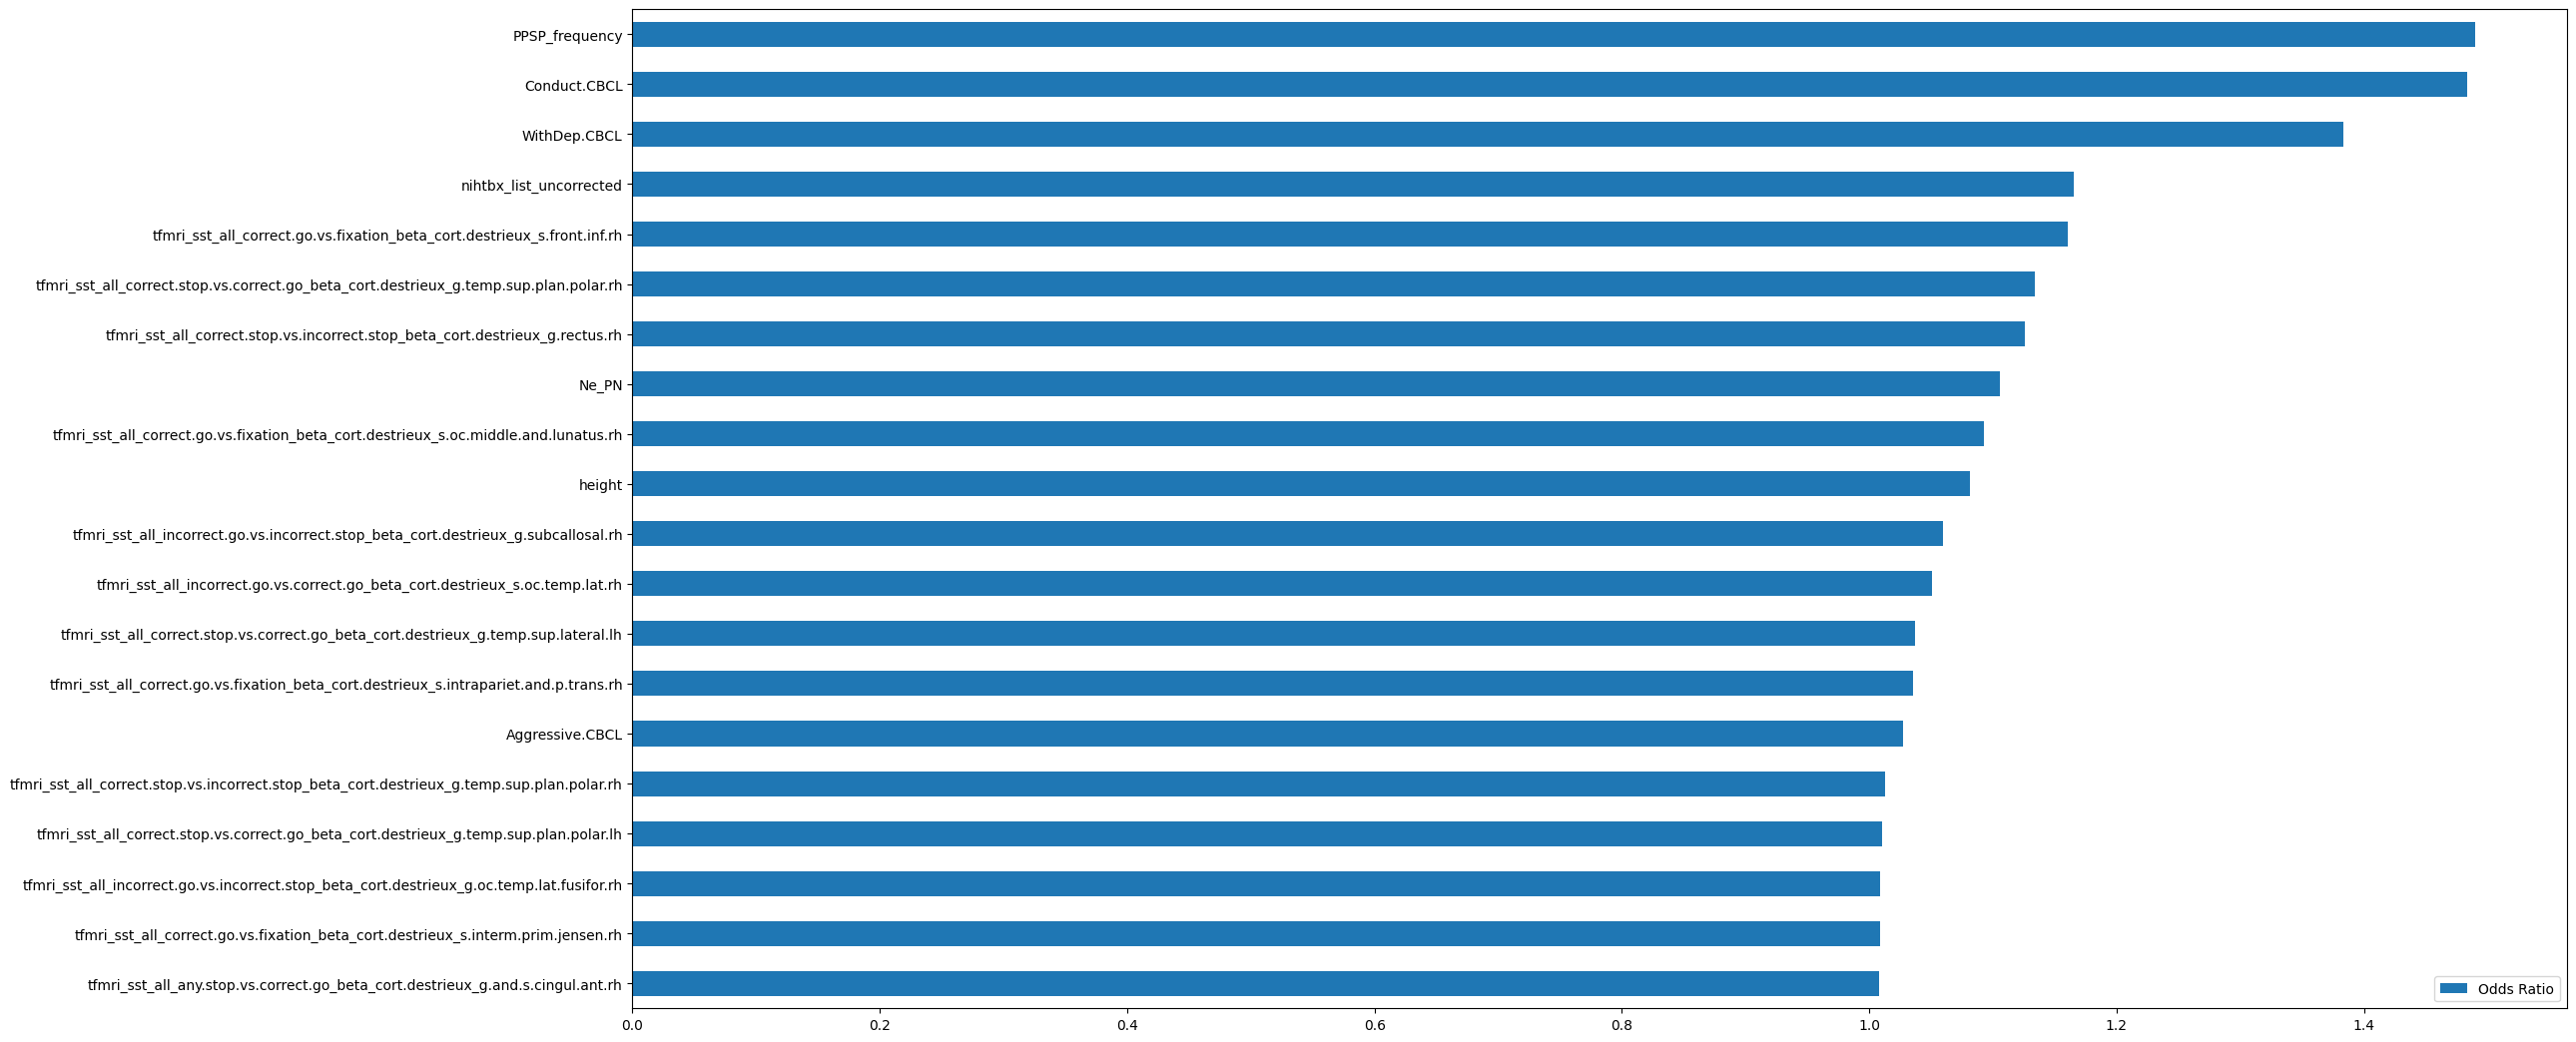

In [140]:
feature_odds = pd.DataFrame(odds_ratios, index=feature_names,
                            columns=['Odds Ratio'])
feature_odds = feature_odds.sort_values(by='Odds Ratio', ascending=False)
FI_plot = feature_odds.head(20).plot(figsize=(25,13), kind='barh').invert_yaxis()

## **ROC Comparison**

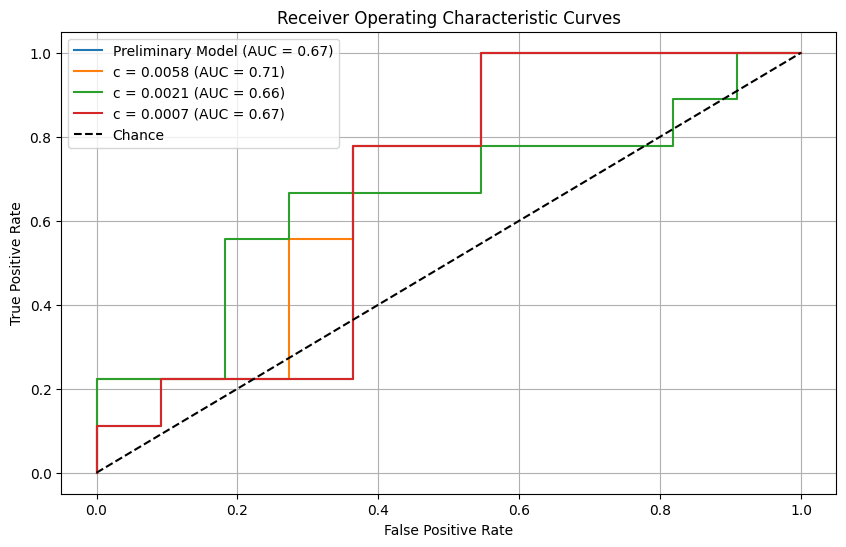

In [141]:
auc_list = []
store_auc(X_test, y_test, 'Preliminary Model', log_reg)
store_auc(X_test, y_test, 'c = 0.0058', log_reg1)
store_auc(X_test, y_test, 'c = 0.0021', log_reg2)
store_auc(X_test, y_test, 'c = 0.0007', log_reg3)
auc_compare_plot(auc_list)